### Oversampling with VAE - from tensorflow / tabular data 

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from os.path import exists
import pandas as pd
pd.options.display.max_rows
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve
import numpy as np
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 1. Load the data and change columns names
data = pd.read_excel('final.xlsm', header=None)
data.columns =['Strain_ID', 'Genome_length', 'Ratio_1kbp_bins_covered', 'Ratio_GC-content_uncovered_bins', 'Ratio_N-content_uncovered_bins', 'Reads_mapped', 'Total_reads', 'Class']
# 2. Drop the Strain_ID column
data = data.drop(['Strain_ID'], axis=1)
# 3. Normalize columns except Class col
sc = StandardScaler()
data[['Genome_length', 'Ratio_1kbp_bins_covered', 'Ratio_GC-content_uncovered_bins', 'Ratio_N-content_uncovered_bins', 'Reads_mapped', 'Total_reads']] = sc.fit_transform(data[['Genome_length', 'Ratio_1kbp_bins_covered', 'Ratio_GC-content_uncovered_bins', 'Ratio_N-content_uncovered_bins', 'Reads_mapped', 'Total_reads']])


# 1. Prepare data: 
def prepare_data(data,random_state=12):
    X = data.drop('Class', axis=1)
    y = data['Class']
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=random_state)
    dftrain = [xtrain, ytrain]
    dftest = [xtest, ytest]
    return pd.concat(dftrain, axis=1), pd.concat(dftest, axis=1)

In [4]:
data.head()

,Genome_length,Ratio_1kbp_bins_covered,Ratio_GC-content_uncovered_bins,Ratio_N-content_uncovered_bins,Reads_mapped,Total_reads,Class
0,0.228558,-0.219520,1.078705,-0.168407,-0.117813,-0.420667,0
1,4.039962,-0.220521,0.485007,-0.154483,-0.117818,-0.420667,0
2,0.075952,-0.220521,0.696596,-0.168520,-0.117818,-0.420667,0
3,2.245584,-0.220521,0.590566,-0.168305,-0.117818,-0.420667,0
4,0.608627,-0.220521,0.683660,-0.168520,-0.117818,-0.420667,0


In [5]:
data.to_excel('data.xlsx')

In [6]:
# Use the function to obtain 2 dataframes: 
dftrain, dftest = prepare_data(data)

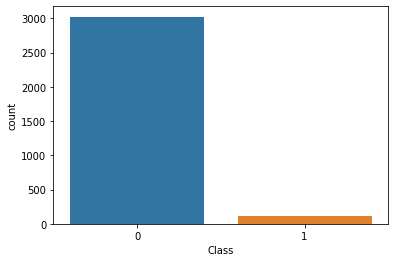

In [7]:
sns.countplot(data['Class']) # initial distribution of data 

In [8]:
# 2. Strains function: 
def strain(dftrain, dftest):
    ''' 1. select only Class = 1 values '''
    strain = dftrain[dftrain.Class==1].sample(frac=1)
    ''' 2. drop class from the dataset '''
    strain = strain.drop(['Class'], axis=1)
    straintest = dftest[dftest.Class==1].sample(frac=1)
    straintest = straintest.drop(['Class'], axis=1)
    return strain, straintest  

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Reshape
from tensorflow.keras import Sequential
import time
import numpy as np

In [10]:
# This code is taken from Tensorflow tutorial on VAEs. It's turned from a CNN to a simple neuralnet which is more appropriate for our case here.

# almost the standard for activation these days
relu = tf.nn.relu


class VAE(tf.keras.Model):
    """
    A VAE class inhereted from keras.Model

    parameters:
    ndim (int): number of dimensions of the input data
    latent_dim (int): number of dimensions of the latent variable

    attributes:
    ndim (int): number of dimensions of the input
    latent_dim (int): number of dimensions of the latent variable
    inference_net (keras.Sequential): The inference model that takes an input of size=(None, ndim) and return a matrix of size=(None, latent_dim)
    generative_net (keras.Sequential): The generative model that takes an input of size=(None, latent_dim) and return a matrix of size=(None, ndim)
    """
    def __init__(self, ndim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim  
        self.ndim = ndim        
        self.inference_net = Sequential(
            [
                InputLayer(input_shape=(ndim,)),
                Dense(100, activation=relu),
                Dense(2 * latent_dim)
            ]
        )
        
        self.generative_net = Sequential(
            [
                InputLayer(input_shape=(latent_dim,)),
                Dense(100, activation=relu),
                Dense(ndim)
            ])

    @tf.function
    def sample(self, num_samples=100, eps=None):
        """
        Given an input noise of size (num_samples, latent_dim), generate samples of size (num_samples, ndim)

        parameters:
        num_samples (int): number of samples
        eps (numpy.ndarray): input noise. if specified, num_samples is ignored

        returns:
        numpy.ndarray: the decoded samples
        """
        if eps is None:
            eps = tf.random.normal(shape=(num_samples, self.latent_dim))
        return self.decode(eps)

    def encode(self, x):
        """
        
        parameters:
        x (numpy.ndarray): the input data with size (None, ndim)

        returns:
        numpy.ndarray: the mean of the latent variables
        numpy.ndarray: the log variance of the latent variables
        """
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        """
        Reparameterize the input for backpropagation

        parameters:
        mean (numpy.ndarray): the mean of the latent variables
        logvar (numpy.ndarray): the log variance of the latent variables

        returns:
        numpy.ndarray: the noise samples from a normal distribution around mean with standard deviation exp(logvar / 2)
        """
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z):
        """
        Given an input noise generates the decoded samples

        parameters:
        z (numpy.ndarray): the input noise (None, latent_dim)

        returns:
        numpy.ndarray: the decoded samples of size (None, ndim)
        """
        return self.generative_net(z)

In [11]:
# a function for computing the KL term of Gaussian distribution
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-0.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
                         axis=raxis)

# a function to compute the loss of the VAE
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    logvar = tf.clip_by_value(logvar, -88., 88.)
    z = model.reparameterize(mean, logvar)
    xmean = model.decode(z)
    logpx_z = -tf.reduce_sum((x - xmean) ** 2, axis=1)  # ad-hoc l2 loss that is pretty close to log-prob of a gaussian distribution withtout taking into account the variance
    logpz = log_normal_pdf(z, 0.0, 0.0)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

# A function that given the model computes the loss, the gradients and apply the parameter update
@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [12]:
def train(xtrain, xtest, model=None, load=False, filepath=None):
    optimizer = tf.keras.optimizers.Adam(1e-3)
    epochs = 2000
    latent_dim = 6 # number of our columns
    num_train, ndim = xtrain.shape
    num_test, _ = xtest.shape
    if model is None:
        model = VAE(ndim, latent_dim)
    if load and filepath is not None:
        model.load_weights(filepath=filepath)
        return model
    else:
        batch_size = 32
        train_dataset = tf.data.Dataset.from_tensor_slices(xtrain.values.astype(np.float32)).shuffle(num_train).batch(
            batch_size)

        test_dataset = tf.data.Dataset.from_tensor_slices(xtest.values.astype(np.float32)).shuffle(num_test).batch(num_test)

        for epoch in range(1, epochs + 1):
            start_time = time.time()
            for train_x in train_dataset:
                compute_apply_gradients(model, train_x, optimizer)
            end_time = time.time()

            if epoch % 100 == 0:
                loss = tf.keras.metrics.Mean()
                for test_x in test_dataset:
                    loss(compute_loss(model, test_x))
                elbo = -loss.result()
                print('Epoch: {}, Test set psudo-ELBO: {}, '
                      'time elapse for current epoch {}'.format(epoch, elbo, end_time - start_time))
                model.save_weights('saved_models/model_%d_at_%d' % (latent_dim, epoch))
    return model

In [13]:
# function to increase the 1 of Class 
def increasing(data, model):
    np.random.seed(12)
    ''' num_samples = number of values of majority class (0) '''
    num_samples = num_samples = data['Class'].value_counts()[0] - data['Class'].value_counts()[1]  # values of class == 1 
    samples = model.sample(num_samples=num_samples).numpy()
    ''' creating new dataframe with sampled values '''
    dfnew = pd.DataFrame(samples, columns=data.columns.drop('Class'))
    dfnew['Class'] = np.ones(len(samples), dtype=np.int)
    # dfnew = pd.concat((data, dfnew), ignore_index=True).sample(frac=1)
    return dfnew

In [14]:
# Use the function to obtain 2 dataframes: 
dftrain, dftest = prepare_data(data)
# get the strains'presence distribution 
strain, straintest = strain(dftrain, dftest)
# get the traied VAE model
model = train(strain, straintest)

Epoch: 100, Test set psudo-ELBO: -7.6699910163879395, time elapse for current epoch 0.007887125015258789
Epoch: 200, Test set psudo-ELBO: -6.738650798797607, time elapse for current epoch 0.00783395767211914
Epoch: 300, Test set psudo-ELBO: -6.742164611816406, time elapse for current epoch 0.008627891540527344
Epoch: 400, Test set psudo-ELBO: -6.4114909172058105, time elapse for current epoch 0.008809089660644531
Epoch: 500, Test set psudo-ELBO: -6.138607025146484, time elapse for current epoch 0.009299993515014648
Epoch: 600, Test set psudo-ELBO: -5.405642032623291, time elapse for current epoch 0.012384891510009766
Epoch: 700, Test set psudo-ELBO: -6.496571063995361, time elapse for current epoch 0.00801992416381836
Epoch: 800, Test set psudo-ELBO: -6.015525817871094, time elapse for current epoch 0.009629964828491211
Epoch: 900, Test set psudo-ELBO: -5.634790897369385, time elapse for current epoch 0.011983871459960938
Epoch: 1000, Test set psudo-ELBO: -5.379653453826904, time elaps

In [15]:
# augment the data using the VAE model
data_increased = increasing(dftrain, model)

In [16]:
data.groupby('Class').mean() #1.53619 and 1.532687

,Genome_length,Ratio_1kbp_bins_covered,Ratio_GC-content_uncovered_bins,Ratio_N-content_uncovered_bins,Reads_mapped,Total_reads
Class,,,,,,
0,-0.016082,-0.06098,0.016543,0.003079,-0.060841,-0.005691
1,0.405132,1.53619,-0.416753,-0.077574,1.532687,0.143355


In [17]:
data_increased.groupby('Class').mean() #1.586048 and 1.500616

,Genome_length,Ratio_1kbp_bins_covered,Ratio_GC-content_uncovered_bins,Ratio_N-content_uncovered_bins,Reads_mapped,Total_reads
Class,,,,,,
1,0.234057,1.60099,-0.408038,-0.135459,1.427738,0.182888


In [18]:
data_increased.shape # 2322

(2322, 7)

In [19]:
data_increased.to_excel('data_increased.xlsx')

In [20]:
def augment_data_interpolation(data, model):
    num_samples = data['Class'].value_counts()[0] - data['Class'].value_counts()[1]
    X = data[data['Class'] == 1].drop(['Class'], axis=1)
    z, _ = model.encode(X.values.astype(np.float32))
    z1 = pd.DataFrame(z).sample(frac=num_samples / len(z), replace=True)
    z2 = z1.sample(frac=1)
    r = np.random.rand(*z1.shape)
    z = r * z1.values + (1 - r) * z2.values
    samples = model.decode(z.astype(np.float32)).numpy()
    dfnew = pd.DataFrame(samples, columns=data.columns.drop('Class'))
    dfnew['Class'] = np.ones(len(samples), dtype=np.int)
    # dfnew = pd.concat((data, dfnew), ignore_index=True).sample(frac=1)
    return dfnew

In [21]:
data_interpolated = augment_data_interpolation(data, model)

In [22]:
data_interpolated.groupby('Class').mean()

,Genome_length,Ratio_1kbp_bins_covered,Ratio_GC-content_uncovered_bins,Ratio_N-content_uncovered_bins,Reads_mapped,Total_reads
Class,,,,,,
1,0.21907,1.516348,-0.481275,-0.160251,1.043895,-0.000749


In [23]:
data.groupby('Class').mean()

,Genome_length,Ratio_1kbp_bins_covered,Ratio_GC-content_uncovered_bins,Ratio_N-content_uncovered_bins,Reads_mapped,Total_reads
Class,,,,,,
0,-0.016082,-0.06098,0.016543,0.003079,-0.060841,-0.005691
1,0.405132,1.53619,-0.416753,-0.077574,1.532687,0.143355


In [24]:
data_interpolated.shape

(2903, 7)

In [25]:
# 1. Merging the new and the original data:
merged_data = pd.concat((data, data_increased), ignore_index=True) # .sample(frac=1)

# 2. Shuffle data 
from sklearn.utils import shuffle
merged_data = shuffle(merged_data)

In [26]:
merged_data.head()

,Genome_length,Ratio_1kbp_bins_covered,Ratio_GC-content_uncovered_bins,Ratio_N-content_uncovered_bins,Reads_mapped,Total_reads,Class
2109,-0.398347,-0.211648,-1.529774,-0.167432,-0.113029,-0.619181,0
4661,-0.115448,3.012359,-0.487116,-0.017871,6.801397,1.447541,1
5297,2.645734,2.204056,0.077926,-0.387763,0.512216,-0.405978,1
1107,-0.793125,-0.183680,0.829575,-0.168520,-0.117813,1.944562,0
969,-0.410265,-0.220521,1.647923,-0.168520,-0.117818,1.944562,0


In [27]:
merged_data.to_excel('merged_data.xlsx')

In [28]:
# Bar plot with ggplot of SMOTE distribution 
from plotnine import *
p = ggplot(merged_data) + geom_bar(aes(x='Class'), fill = "yellow", colour = "blue")
p
ggsave(plot = p, filename = 'Final_code_TFM', path = "/Users/ferdinandosquitieri/Desktop/TFM /ML")
merged_data.shape

(5465, 7)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       567
           1       0.98      1.00      0.99       643

    accuracy                           0.99      1210
   macro avg       0.99      0.99      0.99      1210
weighted avg       0.99      0.99      0.99      1210

[[554  13]
 [  1 642]]
0.011570247933884297


AttributeError: 'numpy.ndarray' object has no attribute 'counts'

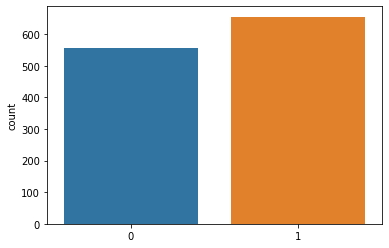

In [61]:
# SMOTE 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
# Defining X and y 
X = data.drop(['Class'], axis = 1 )
y = data['Class']

# Resampling with SMOTE algorithm 
X_smote, y_smote = SMOTE().fit_resample(X, y)

# Splitting data 
xtrain_sm, xtest_sm, ytrain_sm, ytest_sm = train_test_split(X_smote, y_smote, test_size=0.2, random_state=12)

# Testing the models with SMOTE 
smote = SMOTE(random_state=12)
pipeline = Pipeline([('smote', smote), ('rfc', RandomForestClassifier(random_state=12))]) # creating the pipeline we want to use  
pipeline.fit(xtrain_sm, ytrain_sm) # fitting  
pred_smote = pipeline.predict(xtest_sm) # predicting 
print(classification_report(ytest_sm, pred_smote)) # results
print(confusion_matrix(ytest_sm,pred_smote))
print(mean_absolute_error(ytest_sm, pred_smote))
sns.countplot(pred_smote)

# 2 

pipeline_svm = Pipeline([('smote', smote), ('svm', svm.SVC(random_state=12))]) # creating the pipeline we want to use  
pipeline_svm.fit(xtrain_sm, ytrain_sm) # fitting  
pred_smote = pipeline_svm.predict(xtest_sm) # predicting 
print(classification_report(ytest_sm, pred_smote)) # results
print(confusion_matrix(ytest_sm,pred_smote))
print(mean_absolute_error(ytest_sm, pred_smote))
sns.countplot(pred_smote)

# 3

pipeline_lr = Pipeline([('smote', smote), ('lr', LogisticRegression(random_state=12))]) # creating the pipeline we want to use  
pipeline_lr.fit(xtrain_sm, ytrain_sm) # fitting  
pred_smote = pipeline_lr.predict(xtest_sm) # predicting 
print(classification_report(ytest_sm, pred_smote)) # results
print(confusion_matrix(ytest_sm,pred_smote))
print(mean_absolute_error(ytest_sm, pred_smote))
sns.countplot(pred_smote)

final_results = pd.DataFrame({'Model' : ['Random Forest Classifier', 'SVM', 'Logistic Regression'], 'F1-score' : [0.99, 0.76, 0.75]})
final_results

In [62]:
predsmote = pd.DataFrame(pred_smote, columns = ['Class'])
predsmote.to_excel('predsmote.xlsx')

In [30]:
# Bar plot with ggplot of SMOTE distribution 
from plotnine import *
ggplot(predsmote) + geom_bar(aes(x='Class'), fill = "yellow", colour = "blue")

NameError: name 'predsmote' is not defined

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        23
           1       0.93      1.00      0.96        25

    accuracy                           0.96        48
   macro avg       0.96      0.96      0.96        48
weighted avg       0.96      0.96      0.96        48

[[21  2]
 [ 0 25]]
0.041666666666666664
              precision    recall  f1-score   support

           0       0.68      0.74      0.71        23
           1       0.74      0.68      0.71        25

    accuracy                           0.71        48
   macro avg       0.71      0.71      0.71        48
weighted avg       0.71      0.71      0.71        48

[[17  6]
 [ 8 17]]
0.2916666666666667
              precision    recall  f1-score   support

           0       0.77      0.43      0.56        23
           1       0.63      0.88      0.73        25

    accuracy                           0.67        48
   macro avg       0.70      0.66      0.64       

,Model,F1-score
0,Random Forest Classifier,0.96
1,SVM,0.71
2,Logistic Regression,0.73


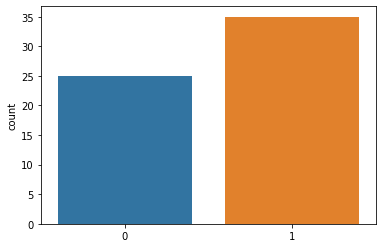

In [63]:
# Cluster Centroids 
from imblearn.under_sampling import ClusterCentroids

CC = ClusterCentroids(random_state=12)
X_res, y_res = CC.fit_sample(X, y)
xtrain_cc, xtest_cc, ytrain_cc, ytest_cc = train_test_split(X_res, y_res, test_size=0.2, random_state=12)

# testing 

pipeline_cc = Pipeline([('CC', CC), ('rfc', RandomForestClassifier(random_state=12))]) # creating the pipeline we want to use  
pipeline_cc.fit(xtrain_cc, ytrain_cc) # fitting  
pred_cc = pipeline_cc.predict(xtest_cc) # predicting 
print(classification_report(ytest_cc, pred_cc)) # results
print(confusion_matrix(ytest_cc,pred_cc))
print(mean_absolute_error(ytest_cc, pred_cc))
sns.countplot(pred_cc)

# 2 
pipeline_cc_svm = Pipeline([('CC', CC), ('svm', svm.SVC(random_state=12))]) # creating the pipeline we want to use  
pipeline_cc_svm.fit(xtrain_cc, ytrain_cc) # fitting  
pred_cc_svm = pipeline_cc_svm.predict(xtest_cc) # predicting 
print(classification_report(ytest_cc, pred_cc_svm)) # results
print(confusion_matrix(ytest_cc,pred_cc_svm))
print(mean_absolute_error(ytest_cc, pred_cc_svm))
sns.countplot(pred_cc_svm)

# 3 
pipeline_cc_lr = Pipeline([('CC', CC), ('lr', LogisticRegression(random_state=12))]) # creating the pipeline we want to use  
pipeline_cc_lr.fit(xtrain_cc, ytrain_cc) # fitting  
pred_cc_lr = pipeline_cc_lr.predict(xtest_cc) # predicting 
print(classification_report(ytest_cc, pred_cc_lr)) # results
print(confusion_matrix(ytest_cc,pred_cc_lr))
print(mean_absolute_error(ytest_cc, pred_cc_lr))
sns.countplot(pred_cc_lr)


final_results_cc = pd.DataFrame({'Model' : ['Random Forest Classifier', 'SVM', 'Logistic Regression'], 'F1-score' : [0.96, 0.71, 0.73]})

final_results_cc




(48,)

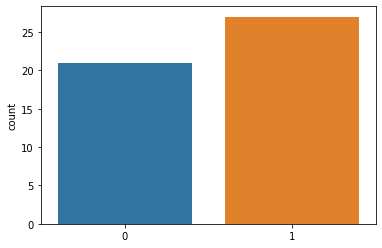

In [58]:
sns.countplot(pred_cc)

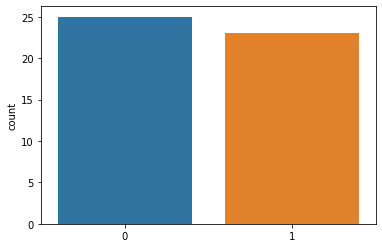

In [54]:
sns.countplot(pred_cc_svm)


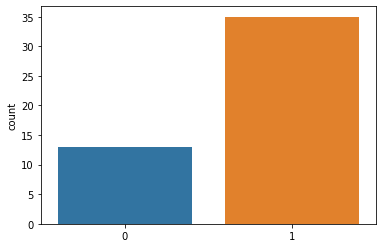

In [56]:
sns.countplot(pred_cc_lr)

In [64]:
predcentroids = pd.DataFrame(pred_cc, columns = ['Class'])
predcentroids.to_excel('Predict_cc.xlsx')
predcentroids[predcentroids.Class==0].shape

(21, 1)

In [ ]:
p = ggplot(predcentroids) + geom_bar(aes(x='Class'), fill = "yellow", colour = "blue")
ggsave(plot = p, filename = 'Final_code_TFM', path = "/Users/ferdinandosquitieri/Desktop/TFM /ML")

In [32]:
# Testing the models on the new data 
# Defining X and Y 
X_final = merged_data.drop('Class', axis=1) # data increased with VAE 
y_final = merged_data['Class']

# Split the data 
xtrain_f, xtest_f, ytrain_f, ytest_f = train_test_split(X_final, y_final, test_size=0.2, random_state=12)

In [32]:
# Model 1 
from sklearn.ensemble import GradientBoostingClassifier # model 1 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error
import xgboost as xgb # model 2
from sklearn.ensemble import AdaBoostClassifier # model 3
from sklearn.ensemble import RandomForestClassifier # model 4 
from sklearn import svm # model 5 
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression # model 6

In [34]:
gbc = GradientBoostingClassifier(random_state=12)
gbc.fit(xtrain_f,ytrain_f)
predict_gbc = gbc.predict(xtest_f)

print(classification_report(ytest_f, predict_gbc))
print(confusion_matrix(ytest_f, predict_gbc))

# error between data generated and original data 
print(mean_absolute_error(predict_gbc, ytest_f))

# Calculating Sensitivity and Specificity from confusion matrix : 
cm1 = (confusion_matrix(ytest_f, predict_gbc)) 
total1 = sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1 = (cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1]) #  TP / (TP+FN)
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])  # TN / (TN + FP)
print('Specificity : ', specificity1)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       614
           1       0.99      0.98      0.98       479

    accuracy                           0.98      1093
   macro avg       0.98      0.98      0.98      1093
weighted avg       0.98      0.98      0.98      1093

[[608   6]
 [ 11 468]]
0.01555352241537054
Accuracy :  0.9844464775846294
Sensitivity :  0.990228013029316
Specificity :  0.9770354906054279


In [35]:
# Model 2 
xgb_boost = xgb.XGBClassifier(random_state=12)
xgb_boost.fit(xtrain_f, ytrain_f)
predict_xgb_boost = xgb_boost.predict(xtest_f)

print(classification_report(ytest_f, predict_xgb_boost))
print(confusion_matrix(ytest_f, predict_xgb_boost))

# error between data generated and original data 
print(mean_absolute_error(predict_xgb_boost, ytest_f))

# Calculating Sensitivity and Specificity from confusion matrix : 
cm2 = (confusion_matrix(ytest_f, predict_xgb_boost)) 
total2 = sum(sum(cm2))
#####from confusion matrix calculate accuracy
accuracy2 = (cm2[0,0]+cm2[1,1])/total2
print ('Accuracy : ', accuracy2)

sensitivity2 = cm2[0,0]/(cm2[0,0]+cm2[0,1]) #  TP / (TP+FN)
print('Sensitivity : ', sensitivity2 )

specificity2 = cm2[1,1]/(cm2[1,0]+cm2[1,1])  # TN / (TN + FP)
print('Specificity : ', specificity2)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       614
           1       0.99      0.99      0.99       479

    accuracy                           0.99      1093
   macro avg       0.99      0.99      0.99      1093
weighted avg       0.99      0.99      0.99      1093

[[609   5]
 [  4 475]]
0.008234217749313814
Accuracy :  0.9917657822506862
Sensitivity :  0.99185667752443
Specificity :  0.9916492693110647


In [36]:
# Model 3 
ada = AdaBoostClassifier(random_state=12)
ada.fit(xtrain_f,ytrain_f)
predict_ada = ada.predict(xtest_f)

print(classification_report(ytest_f, predict_ada))
print(confusion_matrix(ytest_f, predict_ada))

# error between data generated and original data 
print(mean_absolute_error(predict_ada, ytest_f))

# Calculating Sensitivity and Specificity from confusion matrix : 
cm = (confusion_matrix(ytest_f, predict_ada)) 
total = sum(sum(cm))
#####from confusion matrix calculate accuracy
accuracy = (cm[0,0]+cm[1,1])/total
print ('Accuracy : ', accuracy)

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1]) #  TP / (TP+FN)
print('Sensitivity : ', sensitivity )

specificity = cm[1,1]/(cm[1,0]+cm[1,1])  # TN / (TN + FP)
print('Specificity : ', specificity)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       614
           1       0.99      0.98      0.98       479

    accuracy                           0.99      1093
   macro avg       0.99      0.98      0.99      1093
weighted avg       0.99      0.99      0.99      1093

[[608   6]
 [ 10 469]]
0.01463860933211345
Accuracy :  0.9853613906678865
Sensitivity :  0.990228013029316
Specificity :  0.9791231732776617


In [37]:
# Model 4 
rfc = RandomForestClassifier(n_estimators = 200, random_state = 12)
rfc.fit(xtrain_f, ytrain_f)
pred_rfc = rfc.predict(xtest_f)

print(classification_report(ytest_f, pred_rfc))
print(confusion_matrix(ytest_f, pred_rfc))

# Calculating Sensitivity and Specificity from confusion matrix : 
cm1 = (confusion_matrix(ytest_f, pred_rfc)) 
total1 = sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1 = (cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1]) #  TP / (TP+FN)
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])  # TN / (TN + FP)
print('Specificity : ', specificity1)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       614
           1       0.99      0.99      0.99       479

    accuracy                           0.99      1093
   macro avg       0.99      0.99      0.99      1093
weighted avg       0.99      0.99      0.99      1093

[[611   3]
 [  4 475]]
Accuracy :  0.9935956084172004
Sensitivity :  0.995114006514658
Specificity :  0.9916492693110647


In [38]:
# Model 5 
SVM = svm.SVC(random_state = 12)
SVM.fit(xtrain_f, ytrain_f)
pred_SVM = SVM.predict(xtest_f)

print(classification_report(ytest_f, pred_SVM)) 
print(confusion_matrix(ytest_f, pred_SVM)) 

# Calculating Sensitivity and Specificity from confusion matrix : 
cm2 = (confusion_matrix(ytest_f, pred_SVM)) 
total2=sum(sum(cm2))
#####from confusion matrix calculate accuracy
accuracy2=(cm2[0,0]+cm2[1,1])/total2
print ('Accuracy : ', accuracy2)

sensitivity2 = cm2[0,0]/(cm2[0,0]+cm2[0,1]) #  TP / (TP+FN)
print('Sensitivity : ', sensitivity2 )

specificity2 = cm2[1,1]/(cm2[1,0]+cm2[1,1]) # TN / (TN + FP)
print('Specificity : ', specificity2)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       614
           1       0.90      0.84      0.87       479

    accuracy                           0.89      1093
   macro avg       0.89      0.88      0.88      1093
weighted avg       0.89      0.89      0.89      1093

[[567  47]
 [ 76 403]]
Accuracy :  0.8874656907593779
Sensitivity :  0.9234527687296417
Specificity :  0.8413361169102297


In [39]:
# Model 6 
logreg = LogisticRegression(solver='lbfgs', random_state = 12)
logreg.fit(xtrain_f, ytrain_f)
pred_logreg = logreg.predict(xtest_f)

print(classification_report(ytest_f, pred_logreg)) 
print(confusion_matrix(ytest_f, pred_logreg)) 

# Calculating Sensitivity and Specificity from confusion matrix : 
cm3 = (confusion_matrix(ytest_f, pred_logreg)) 
total3=sum(sum(cm3))
#####from confusion matrix calculate accuracy
accuracy3=(cm3[0,0]+cm3[1,1])/total3
print ('Accuracy : ', accuracy3)

sensitivity3 = cm3[0,0]/(cm3[0,0]+cm3[0,1]) #  TP / (TP+FN)
print('Sensitivity : ', sensitivity3 )

specificity3 = cm3[1,1]/(cm3[1,0]+cm3[1,1]) # TN / (TN + FP)
print('Specificity : ', specificity3)

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       614
           1       0.87      0.74      0.80       479

    accuracy                           0.84      1093
   macro avg       0.84      0.83      0.83      1093
weighted avg       0.84      0.84      0.84      1093

[[561  53]
 [124 355]]
Accuracy :  0.8380603842634949
Sensitivity :  0.9136807817589576
Specificity :  0.7411273486430062


In [40]:
# Hyperparameters tuning - Model 1 
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV # Grid Search 
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

print('Parameters currently in use:\n')
print(gbc.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'presort': 'deprecated', 'random_state': 12, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [41]:
tuned_params = [{'ccp_alpha' : [0.0,0.5,0.7], 'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'n_estimators':[100,200,400,600,800] }]

In [42]:
np.random.seed(12)
tuned_gbc = GridSearchCV(GradientBoostingClassifier(), tuned_params, cv = 5, scoring = 'f1_macro')
tuned_gbc.fit(xtrain, ytrain)
tuned_gbc.predict(xtest)
tuned_gbc.cv_results_

gbc_table = pd.DataFrame(tuned_gbc.cv_results_)
gbc_table

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.720062,0.049945,0.007997,0.001962,0,0.0001,100,"{'ccp_alpha': 0.0, 'learning_rate': 0.0001, 'n...",0.336986,0.336763,0.336763,0.336763,0.336763,0.336807,0.000089,30
1,1.457903,0.040496,0.008410,0.001611,0,0.0001,200,"{'ccp_alpha': 0.0, 'learning_rate': 0.0001, 'n...",0.743494,0.698620,0.705219,0.681174,0.712117,0.708125,0.020455,29
2,3.211356,0.324998,0.011052,0.001091,0,0.0001,400,"{'ccp_alpha': 0.0, 'learning_rate': 0.0001, 'n...",0.928565,0.901622,0.910855,0.881075,0.889028,0.902229,0.016674,28
3,4.558359,0.356853,0.013491,0.001891,0,0.0001,600,"{'ccp_alpha': 0.0, 'learning_rate': 0.0001, 'n...",0.928565,0.910710,0.915867,0.893463,0.898106,0.909342,0.012589,26
4,6.018112,0.269973,0.015880,0.002042,0,0.0001,800,"{'ccp_alpha': 0.0, 'learning_rate': 0.0001, 'n...",0.928565,0.910710,0.915867,0.893463,0.898106,0.909342,0.012589,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.688310,0.020503,0.005589,0.000582,0.7,0.3,100,"{'ccp_alpha': 0.7, 'learning_rate': 0.3, 'n_es...",0.336986,0.336763,0.336763,0.336763,0.336763,0.336807,0.000089,30
86,1.314400,0.087770,0.005149,0.000485,0.7,0.3,200,"{'ccp_alpha': 0.7, 'learning_rate': 0.3, 'n_es...",0.336986,0.336763,0.336763,0.336763,0.336763,0.336807,0.000089,30
87,3.410891,0.524735,0.010030,0.007068,0.7,0.3,400,"{'ccp_alpha': 0.7, 'learning_rate': 0.3, 'n_es...",0.336986,0.336763,0.336763,0.336763,0.336763,0.336807,0.000089,30
88,6.236772,1.037393,0.007473,0.001439,0.7,0.3,600,"{'ccp_alpha': 0.7, 'learning_rate': 0.3, 'n_es...",0.336986,0.336763,0.336763,0.336763,0.336763,0.336807,0.000089,30


In [ ]:
tuned_gbc.best_score_ # 0.9890390787112274

In [ ]:
# Model 2 
print('Parameters currently in use:\n')
print(xgb_boost.get_params())

In [ ]:
tuned_params_xgb = [{'base_score' : [0.0,0.5,0.7], 'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'n_estimators':[100,200,400,600,800] }]

In [ ]:
np.random.seed(12)
tuned_xgb = GridSearchCV(xgb.XGBClassifier(random_state=12), tuned_params, cv = 5, scoring = 'f1_macro')
tuned_xgb.fit(xtrain, ytrain)
tuned_xgb.cv_results_

xgb_table = pd.DataFrame(tuned_xgb.cv_results_)

In [ ]:
xgb_table

In [ ]:
tuned_xgb.best_params_

In [ ]:
# Model 3 
print('Parameters currently in use:\n')
print(ada.get_params())

In [ ]:
tuned_ada_params = [{'algorithm' : ['SAMME', 'SAMME.R'], 'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'n_estimators':[100,200,400,600,800] }]

In [ ]:
np.random.seed(12)
tuned_ada= GridSearchCV(AdaBoostClassifier(random_state=12), tuned_ada_params, cv = 5, scoring = 'f1_macro')
tuned_ada.fit(xtrain, ytrain)
tuned_ada.cv_results_

ada_table = pd.DataFrame(tuned_ada.cv_results_)
ada_table

In [ ]:
tuned_ada.best_params_

In [ ]:
# Model 4 
print('Parameters currently in use:\n')
print(rfc.get_params())

In [ ]:
tuned_params_rfc = [{'n_estimators' : [100,500,800], 'oob_score' : [False, True], 'ccp_alpha' : [0.0, 0.5, 0.7], 'criterion' : ['gini', 'entropy']}]

In [ ]:
tuned_rfc = GridSearchCV(RandomForestClassifier(random_state = 12), tuned_params_rfc, cv = 5, scoring = 'f1_macro')
tuned_rfc.fit(xtrain, ytrain)
tuned_rfc.cv_results_

rfc_table = pd.DataFrame(tuned_rfc.cv_results_)
rfc_table

In [ ]:
tuned_rfc.best_params_

In [ ]:
# Model 5 
print('Parameters currently in use:\n')
print(SVM.get_params())

In [ ]:
tuned_svm = [{'kernel' : ['rbf'], 'gamma' : [1e-3, 1e-4], 
                    'C' : [1,10,100,1000]},
                   {'kernel' : ['linear'], 'C' : [1,10,100,1000]}]

np.random.seed(123)
tuned_svm = GridSearchCV(svm.SVC(), tuned_svm, cv = 5, scoring = 'f1_macro')
tuned_svm.fit(xtrain,ytrain) #testing 
tuned_svm.best_params_
tuned_svm.cv_results_

svm_table = pd.DataFrame(tuned_svm.cv_results_)
svm_table

In [ ]:
tuned_svm.best_params_

In [ ]:
# Model 6 
print('Parameters currently in use:\n')
print(logreg.get_params())

In [ ]:
tuned_logreg = [{'penalty' : ['l5', 'l1', 'l2', 'l20'],  
                    'C' : [1,10,100,1000],
               'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]

np.random.seed(12)

tuned_logreg = GridSearchCV(LogisticRegression(), tuned_logreg, cv = 5, scoring = 'f1_macro')
tuned_logreg.fit(xtrain,ytrain) #testing 
tuned_logreg.cv_results_

logreg_table = pd.DataFrame(tuned_logreg.cv_results_)
logreg_table

In [ ]:
model_params = {
    'SVM' : {
        'Model': svm.SVC(random_state = 1),
        'Params': {
            'C' : [1,10,100,1000],
            'gamma' : [1e-3, 1e-4], 
        }
    },
    'Random_forest' : {
        'Model': RandomForestClassifier(random_state = 1),
        'Params': {
            'n_estimators' : [100,500,800],
            'oob_score' : [False, True]
        }
    },
    'Logistic_regression' : {
        'Model': LogisticRegression(random_state = 1),
        'Params': {
        'C' : [1,10,100,1000],
            'penalty' : ['l1', 'l2'],
            'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
},
    'Gradient_Boosting' : {
        'Model' : GradientBoostingClassifier(random_state = 1),
        'Params' : {
            'ccp_alpha' : [0.0,0.5,0.7], 
            'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 
            'n_estimators':[100,200,400,600,800]
        }
    },
    
    'XGB_Boosting' : {
        'Model' : xgb.XGBClassifier(random_state = 1),
        'Params' : {
            'base_score' : [0.0,0.5,0.7], 
            'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 
            'n_estimators':[100,200,400,600,800]  
        }
    }, 
    
    'Ada_Boosting' : {
        'Model' : AdaBoostClassifier(random_state = 1),
        'Params' : {
            'algorithm' : ['SAMME', 'SAMME.R'], 
            'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 
            'n_estimators':[100,200,400,600,800]  
        }
    } 
} 

In [ ]:
scores = []
np.random.seed(12)
for model_name, mp in model_params.items():
    final_model = GridSearchCV(mp['Model'], mp['Params'], cv=5, return_train_score=False, scoring='f1_micro')
    final_model.fit(X_final,y_final)
    scores.append({
        'Model': model_name,
        'Best score' : final_model.best_score_,
        'Best params': final_model.best_params_
    })

In [ ]:
final_params_table = pd.DataFrame(scores,columns=['Model', 'Best score', 'Best params']).sort_values(by=['Best score'], ascending=False)

In [ ]:
final_params_table

In [ ]:
final_params_table.iloc[1,2] # to check the best parameters of the XGB_Boosting

In [ ]:
final_model = xgb.XGBClassifier(base_score = 0.7, learning_rate = 0.3, n_estimators = 800, random_state=12)
final_model.fit(xtrain_f, ytrain_f)
final_predict = final_model.predict(xtest_f)

print(classification_report(ytest_f, final_predict))
print(confusion_matrix(ytest_f, final_predict))

# Calculating Sensitivity and Specificity from confusion matrix : 
cm2 = (confusion_matrix(ytest_f, final_predict)) 
total2 = sum(sum(cm2))
#####from confusion matrix calculate accuracy
accuracy2 = (cm2[0,0]+cm2[1,1])/total2
print ('Accuracy : ', accuracy2)

sensitivity2 = cm2[0,0]/(cm2[0,0]+cm2[0,1]) #  TP / (TP+FN)
print('Sensitivity : ', sensitivity2 )

specificity2 = cm2[1,1]/(cm2[1,0]+cm2[1,1])  # TN / (TN + FP)
print('Specificity : ', specificity2)

In [43]:
from sklearn.metrics import plot_confusion_matrix
titles_options = [('Final Model')]
for title in titles_options:
    disp = plot_confusion_matrix(final_model, xtest_f, ytest_f)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

NameError: name 'final_model' is not defined

In [ ]:
sns.countplot(final_predict)

In [ ]:
# Creating pickle object of the final model : 
import pickle    

#save the model
pickle.dump(final_model, open('final_model.sav', 'wb'))
# save the scaler
pickle.dump(sc, open('scaler.sav', 'wb'))